<a href="https://colab.research.google.com/github/tejaswiniramakrishna/Transfer-learning/blob/main/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
keras = tf.keras

In [ ]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [ ]:
SPLIT_WEIGHTS = (8,1,1)
splits = tfds.Split.TRAIN.subsplit(weighted=SPLIT_WEIGHTS)

In [ ]:
(raw_train,raw_validation,raw_test), metadata = tfds.load('cats_vs_dogs', split=list(splits), with_info=True, as_supervised=True)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/2.0.1. Subsequent calls will reuse this data.


In [ ]:
print(raw_test)
print(raw_train)
print(raw_validation)

<DatasetV1Adapter shapes: ((?, ?, 3), ()), types: (tf.uint8, tf.int64)>
<DatasetV1Adapter shapes: ((?, ?, 3), ()), types: (tf.uint8, tf.int64)>
<DatasetV1Adapter shapes: ((?, ?, 3), ()), types: (tf.uint8, tf.int64)>


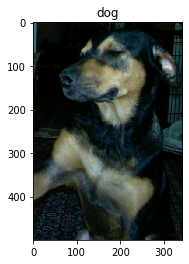

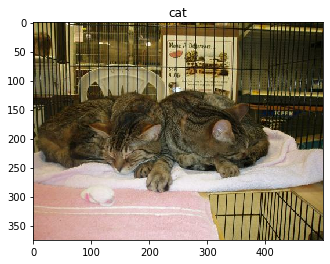

In [ ]:
get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(2):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))


In [ ]:
IMG_SIZE = 160
def format_example(image,label):
  image = tf.cast(image,tf.float32)
  image = (image/127.5)-1
  image = tf.image.resize(image, (IMG_SIZE,IMG_SIZE))
  return image,label

In [ ]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [ ]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [ ]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [ ]:
for image_batch, label_batch in train_batches.take(1):
  pass

In [ ]:
image_batch.shape

TensorShape([Dimension(32), Dimension(160), Dimension(160), Dimension(3)])

In [ ]:
IMG_SHAPE = (IMG_SIZE,IMG_SIZE,3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,include_top= False,weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
predection_layer = keras.layers.Dense(1)
predection_batch = predection_layer(feature_batch_average)
print(predection_batch.shape)

(32, 1)


In [ ]:
model = tf.keras.Sequential([
                             base_model,
                             global_average_layer,
                             predection_layer])
                             


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),
    loss='binary_crossentropy',
    metrics = ['accuracy']
    
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
num_train, num_val,num_test = (
    metadata.splits ['train'].num_examples*weight/10
    for weight in SPLIT_WEIGHTS
)

In [ ]:
initial_epochs = 10
steps_per_epoch = round(num_train)//BATCH_SIZE
validation_steps = 20

In [ ]:
loss0, accuracy0 = model.evaluate(validation_batches,steps=validation_steps)

20/20 [==============================] - 4s 203ms/step - loss: 5.2923 - acc: 0.4375


In [ ]:
history = model.fit(train_batches,
                    epochs = initial_epochs,
                    validation_data = validation_batches)

Epoch 1/10
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


582/582 [==============================] - 94s 161ms/step - loss: 2.1534 - acc: 0.7210 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 2/10
582/582 [==============================] - 84s 145ms/step - loss: 0.9628 - acc: 0.8663 - val_loss: 0.7374 - val_acc: 0.9164
Epoch 3/10
582/582 [==============================] - 86s 148ms/step - loss: 0.6816 - acc: 0.9050 - val_loss: 0.6127 - val_acc: 0.9366
Epoch 4/10
582/582 [==============================] - 88s 151ms/step - loss: 0.5698 - acc: 0.9209 - val_loss: 0.5548 - val_acc: 0.9427
Epoch 5/10
582/582 [==============================] - 88s 151ms/step - loss: 0.5161 - acc: 0.9297 - val_loss: 0.4629 - val_acc: 0.9487
Epoch 6/10
582/582 [==============================] - 88s 152ms/step - loss: 0.4857 - acc: 0.9345 - val_loss: 0.4687 - val_acc: 0.9513
Epoch 7/10
582/582 [==============================] - 88s 152ms/step - loss: 0.4696 - acc: 0.9389 - val_loss: 0.4512 - val_acc: 0.9513
Epoch 8/10
582/582 [==============================] - 89s 

In [ ]:
from keras.preprocessing import image

DOG


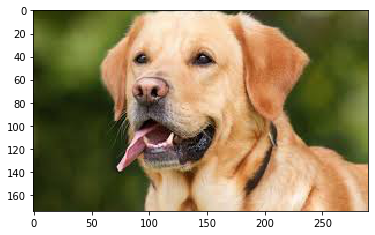

In [ ]:
img = image.load_img("/srv/3.jpeg")
plt.imshow(img)
img = np.array(img)
img = np.expand_dims(img,axis=0)
img = tf.convert_to_tensor(img)
img,label = format_example(img,None)

res = model.predict(img)
if res[0][0] > 0:
  print("DOG")
else:
  print("CAT")